# **EXPLORING SJLR WITHOUT EDGE REMOVAL**

The purpose of this notebook is to explore the possibility of applying the Stochastic Jost and Liu Curvature Rewriting (SJLR) algorithm from Giraldo et al. 2023 without the need for edge removals. As noted in Giraldo et al., the edge removal component of the SJLR algorithm is important to the alleviation of over-smoothing.

However, this comes at the cost of potentially increasing bottlenecks on the system, exacerbating potential over-squeezing issues, as the stochastic nature of the algorithm entails that an edge with high importance (i.e. an edge with a high curvature) may be deleted. Alternative mitigation strategies for over-smoothing in MPNNs exist however, largely involving architectural strategies. This notebook explores a modified SJLR with no deletions ($p_D = 0$) combined with Skipping Connections and Jumping Knowledge Connections, two of these alternative strategies, to explore whether the difference in over-smoothing mitigation can be compensated for without the need for edge deletions.

Much of this notebook is building upon code found in https://github.com/jhonygiraldo/SJLR , however I have made some substantial edits to improve clarity, and readability. The primary advantage of this was to be able to efficiently implement the SJLR algorithm itself. I have also implemented Skipping Connections and Jumping Knowledge Connections myself.

I have tagged each section with the related scripts that the code is derivative of, so you are able to compare against the original repo yourself to see the changes that I have made.

#### Installing prerequisites to set up environment

In [ ]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

#### Random seeds for testing (run this block)

In [ ]:
test_seeds = [
    2406525885, 3164031153, 1454191016, 1583215992, 765984986,
    # 258270452, 3808600642, 292690791, 2492579272, 1660347731,
    # 902096533, 1295255868, 3887601419, 2250799892, 4099160157,
    # 658822373, 1105377040, 1822472846, 2360402805, 2355749367,
    # 2291281609, 1241963358, 3431144533, 623424053, 78533721,
    # 1819244826, 1368272433, 555336705, 1979924085, 1064200250,
    # 256355991, 125892661, 4214462414, 2173868563, 629150633,
    # 525931699, 3859280724, 1633334170, 1881852583, 2776477614,
    # 1576005390, 2488832372, 2518362830, 2535216825, 333285849,
    # 109709634, 2287562222, 3519650116, 3997158861, 3939456016,
    # 4049817465, 2056937834, 4198936517, 1928038128, 897197605,
    # 3241375559, 3379824712, 3094687001, 80894711, 1598990667,
    # 2733558549, 2514977904, 3551930474, 2501047343, 2838870928,
    # 2323804206, 2609476842, 1941488137, 1647800118, 1544748364,
    # 983997847, 1907884813, 1261931583, 4094088262, 536998751,
    # 3788863109, 4023022221, 3116173213, 4019585660, 3278901850,
    # 3321752075, 2108550661, 2354669019, 3317723962, 1915553117,
    # 1464389813, 1648766618, 3423813613, 1338906396, 629014539,
    # 3330934799, 3295065306, 3212139042, 3653474276, 1078114430,
    # 2424918363, 3316305951, 2059234307, 1805510917, 1327514671
]

val_seeds = [4258031807, 3829679737, 3706579387, 789594926,  3628091752]

development_seed = 1684992425


## Compute JLC Metrics

Computing the JLC metrics in one go at the beginning removes the need to compute them multiple times throughout training. During training, JLC metrics only need to be re-evaluated for newly added edges. This heavily reduces computational overhead, and drastically speeds up training.

This block sets up to create pickle files containing all JLC metrics. If the pickle files are already held, there's no need to run the last code block in this section.

### Package Dependencies

In [ ]:
import os
import pickle

import numpy as np
import torch
import torch.nn.functional as functional
from torch_geometric.utils import to_undirected, remove_self_loops
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.datasets import Planetoid, WebKB, Actor

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:87: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:98: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:125: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperators

### Setting up JLC functions

This part of the script is derivative of code blocks from the files:

- `models/JLC_curvature.py` for the functions `jost_liu_curvature`, `compute_jost_liu_curvature` and `compute_JLC_matrices`.


In [ ]:
def jost_liu_curvature(edge_index, n, is_undirected):
    r"""This function computes the Jost & Liu curvature for the input graph.
    The curvature metric is defined on "Ollivier's Ricci curvature, local clustering and
    curvature dimension inequalities on graphs" <https://arxiv.org/pdf/1103.4037.pdf>`_ paper

    Args:
        edge_index (LongTensor): The edge indices.
        n (int): Number of nodes.
        is_undirected (bool, optional): If set to :obj:`True`, will assume the graph is undirected
    """
    adj = torch.zeros((n, n))
    if is_undirected:
        adj[edge_index[0], edge_index[1]] = 1
        adj[edge_index[1], edge_index[0]] = 1
    else:
        adj[edge_index[0], edge_index[1]] = 1
    num_edges = edge_index.shape[1]
    jost_liu_vector = torch.zeros((num_edges,))
    for i in range(0, num_edges):
        edge = edge_index[:, i]
        node_x = edge[0]
        node_y = edge[1]
        jost_liu_vector[i] = compute_jost_liu_curvature(adj, node_x, node_y)
    return jost_liu_vector


def compute_jost_liu_curvature(adj, node_x, node_y, is_adj_sparse=False, s_x=None, s_y=None):
    r"""This function computes the Jost & Liu curvature based on the nodes node_x and node_y.
    The curvature metric is defined on "Ollivier's Ricci curvature, local clustering and
    curvature dimension inequalities on graphs" <https://arxiv.org/pdf/1103.4037.pdf>`_ paper

    Args:
        adj (sparse LongTensor or LongTensor): The adjacency matrix of the graph.
        node_x (int): First node of the base edge.
        node_y (int): Second node of the base edge.
        graph_degrees (LongTensor): Vector with the degrees of each node.
        is_adj_sparse (bool): If set to :obj:`True`, the adj variable is a sparse tensor.
        s_x (LongTensor): Vector of neighbors of node_x
        s_y (LongTensor): Vector of neighbors of node_y
    """
    # Computes neighborhood of the base nodes when the input adj matrix is a in sparse representation
    if is_adj_sparse and (s_x is None) and (s_y is None):
        s_x = adj[node_x].coalesce().indices()[0]
        s_y = adj[node_y].coalesce().indices()[0]
    # Computes neighborhood of the base nodes when the input adj matrix is in dense representation
    elif (s_x is None) and (s_y is None):
        s_x = torch.where(adj[node_x] > 0)[0]
        s_y = torch.where(adj[node_y] > 0)[0]
    set_triangles = np.intersect1d(s_x, s_y)  # The set of triangles is computed as the intersection of the neighbors
    # of each based node
    number_triangles = set_triangles.shape[0]
    degree_x = torch.Tensor([s_x.shape[0]])
    degree_y = torch.Tensor([s_y.shape[0]])
    max_degree = torch.max(degree_x, degree_y)
    min_degree = torch.min(degree_x, degree_y)
    # First term of Jost Liu Curvature equation
    first_term = (1 - (1 / degree_x) - (1 / degree_y) - (number_triangles / min_degree))
    # Second term of Jost Liu Curvature equation
    second_term = (1 - (1 / degree_x) - (1 / degree_y) - (number_triangles / max_degree))
    return -1 * torch.max(torch.Tensor([0]), first_term) - 1 * torch.max(torch.Tensor([0]), second_term) + \
           (number_triangles / max_degree)

In [ ]:
def compute_JLC_matrices(edge_index, n, n_edges, pA, force_undirected=False):
    edge_index_original = edge_index.clone()
    if force_undirected:
        edge_index = edge_index_original.cpu()
        row, col = edge_index
        index_undirected = torch.where(row > col)[0]
        edge_index = edge_index[:, index_undirected]
        row, col = edge_index
    else:
        edge_index = edge_index.cpu()
        row, col = edge_index
    JLC = jost_liu_curvature(edge_index, n, force_undirected).cpu()

    # Construct matrix_JLC in sparse structure.
    Adj_row_col = torch.LongTensor([row.tolist(), col.tolist()])
    matrix_JLC = torch.sparse.LongTensor(Adj_row_col, JLC)

    # Construct adjacency matrix in sparse structure.
    if force_undirected:
        row, col = edge_index_original.cpu()
        Adj_row_col = torch.LongTensor([row.tolist(), col.tolist()])
    Adj = torch.sparse.LongTensor(Adj_row_col, torch.ones((n_edges,)))
    Adj_dense = Adj.to_dense()
    if force_undirected:
        row, col = edge_index.cpu()
        Adj_row_col = torch.cat((edge_index, torch.LongTensor([col.tolist(), row.tolist()])), dim=1)
        JLC_temp = torch.cat((JLC, JLC), dim=0)
        matrix_JLC_temp = torch.sparse.LongTensor(Adj_row_col, JLC_temp)
        matrix_JLC_dense = matrix_JLC_temp.to_dense()
    else:
        matrix_JLC_dense = matrix_JLC.to_dense()

    # Search for the potential good nodes
    JLC_sorted = torch.sort(JLC)
    potential_good_edges_to_add = torch.LongTensor([])
    Adj_complement = torch.zeros((n, n))
    cont = 0

    # Here we assume the graph is undirected
    while potential_good_edges_to_add.shape[0] < 2*pA*n_edges:
        curved_edge = edge_index[:, JLC_sorted.indices[cont]]
        node_x = curved_edge[0].cpu()
        node_y = curved_edge[1].cpu()

        # This neighborhood includes 3-cycles (triangles) only
        S_x_original = Adj[node_x].coalesce().indices()[0]
        S_y_original = Adj[node_y].coalesce().indices()[0]
        indx_node_y = torch.where(S_x_original == node_y)
        S_x = np.delete(S_x_original, indx_node_y, axis=0)
        indx_node_x = torch.where(S_y_original == node_x)
        S_y = np.delete(S_y_original, indx_node_x, axis=0)
        S_x = torch.cartesian_prod(node_y.reshape((1,)), S_x)
        S_y = torch.cartesian_prod(S_y, node_x.reshape((1,)))
        car_prod_Sx_Sy = torch.cat((S_x, S_y), dim=0)

        # See if these edges are in the set of original edges
        existing_edges = Adj_dense[car_prod_Sx_Sy[:,0], car_prod_Sx_Sy[:,1]]
        index_existing_edges = torch.where(existing_edges == 1)
        car_prod_Sx_Sy = np.delete(car_prod_Sx_Sy.cpu(), index_existing_edges[0], axis=0)

        # See if these edges are already added in potential_good_edges_to_add
        existing_edges_in_good_edges = Adj_complement[car_prod_Sx_Sy[:, 0], car_prod_Sx_Sy[:, 1]]
        index_existing_edges = torch.where(existing_edges_in_good_edges == 1)
        car_prod_Sx_Sy = np.delete(car_prod_Sx_Sy.cpu(), index_existing_edges[0], axis=0)
        potential_good_edges_to_add = torch.cat((potential_good_edges_to_add, car_prod_Sx_Sy), dim=0)
        Adj_complement[car_prod_Sx_Sy[:, 0], car_prod_Sx_Sy[:, 1]] = 1
        cont += 1

    # Construct matrix_JLCc in sparse structure.
    matrix_JLCc_temp = torch.zeros((n, n))
    for i, edges_complement in enumerate(potential_good_edges_to_add):
        Adj_row_col_temp = Adj_row_col.clone()
        Adj_row_col_temp = torch.cat((Adj_row_col_temp, edges_complement.reshape((2, 1))), dim=1)
        if force_undirected:
            Adj_row_col_temp = to_undirected(Adj_row_col_temp)
        Adj_temp = torch.sparse.LongTensor(Adj_row_col_temp, torch.ones((Adj_row_col_temp.shape[1],)))

        # Look for edges that form a triangle with the new edge
        S_x_original = Adj[edges_complement[0]].coalesce().indices()[0]
        S_y_original = Adj[edges_complement[1]].coalesce().indices()[0]
        set_triangles = torch.LongTensor(np.intersect1d(S_x_original, S_y_original))  # The set of triangles is computed as the intersection of the neighbors
        S_x = torch.cartesian_prod(edges_complement[0].reshape((1,)), set_triangles)
        S_y = torch.cartesian_prod(edges_complement[1].reshape((1,)), set_triangles)
        edges_with_triangles = torch.cat((S_x, S_y), dim=0)
        JLC_temp_improvement = torch.zeros((edges_with_triangles.shape[0],))
        for j, edge_to_process in enumerate(edges_with_triangles):
            JLC_temp_improvement[j] = compute_jost_liu_curvature(Adj_temp, edge_to_process[0],
                                                                 edge_to_process[1], is_adj_sparse=True)
        JLC_temp_improvement = JLC_temp_improvement - matrix_JLC_dense[edges_with_triangles.T[0], edges_with_triangles.T[1]]
        matrix_JLCc_temp[edges_complement[0], edges_complement[1]] = torch.mean(JLC_temp_improvement)
        if force_undirected:
            matrix_JLCc_temp[edges_complement[1], edges_complement[0]] = matrix_JLCc_temp[
                edges_complement[0], edges_complement[1]]

    # Construct matrix_JLCc in sparse structure.
    matrix_JLCc = torch.sparse.LongTensor(potential_good_edges_to_add.T, matrix_JLCc_temp[potential_good_edges_to_add.T[0], potential_good_edges_to_add.T[1]])
    return matrix_JLC, potential_good_edges_to_add.T, matrix_JLCc_temp[potential_good_edges_to_add.T[0], potential_good_edges_to_add.T[1]]

### Pull datasets using torch_geometric

Functions in this section are derived from:
- `load_data/data.py` for `get_component`, `get_largest_connected_component`, `get_node_mapper`, `remap_edges`, `get_dataset`.

In [ ]:
def get_component(dataset: InMemoryDataset, start: int = 0) -> set:
    visited_nodes = set()
    queued_nodes = set([start])
    row, col = dataset.data.edge_index.numpy()
    while queued_nodes:
        current_node = queued_nodes.pop()
        visited_nodes.update([current_node])
        neighbors = col[np.where(row == current_node)[0]]
        neighbors = [n for n in neighbors if n not in visited_nodes and n not in queued_nodes]
        queued_nodes.update(neighbors)
    return visited_nodes


def get_largest_connected_component(dataset: InMemoryDataset) -> np.ndarray:
    remaining_nodes = set(range(dataset.data.x.shape[0]))
    comps = []
    while remaining_nodes:
        start = min(remaining_nodes)
        comp = get_component(dataset, start)
        comps.append(comp)
        remaining_nodes = remaining_nodes.difference(comp)
    return np.array(list(comps[np.argmax(list(map(len, comps)))]))

def get_node_mapper(lcc: np.ndarray) -> dict:
    mapper = {}
    counter = 0
    for node in lcc:
        mapper[node] = counter
        counter += 1
    return mapper


def remap_edges(edges: list, mapper: dict) -> list:
    row = [e[0] for e in edges]
    col = [e[1] for e in edges]
    row = list(map(lambda x: mapper[x], row))
    col = list(map(lambda x: mapper[x], col))
    return [row, col]

In [ ]:
def homophily_ratio(data):
    same_label_edges = 0
    total_edges = data.edge_index.size(1)  # Number of edges

    # Loop through all edges
    for i in range(total_edges):
        src, dst = data.edge_index[:, i]

        # Check if labels are the same for connected nodes
        if data.y[src] == data.y[dst]:
            same_label_edges += 1

    # Calculate homophily ratio
    homophily = same_label_edges / total_edges
    return homophily

def get_dataset(name: str, use_lcc: bool = True) -> InMemoryDataset:
    path = os.path.join(DATA_PATH, name)
    if name in ['Cora', 'Pubmed']:
        dataset = Planetoid(path, name)
    elif name in ['Cornell', 'Texas']:
        dataset = WebKB(path, name)
    else:
        raise Exception('Unknown dataset.')

    # print(f'{name}: {dataset.data}')
    # print(f'Homophily Ratio: {homophily_ratio(dataset.data)}')

    if use_lcc:
        lcc = get_largest_connected_component(dataset)

        x_new = dataset.data.x[lcc]
        y_new = dataset.data.y[lcc]

        row, col = dataset.data.edge_index.numpy()
        edges = [[i, j] for i, j in zip(row, col) if i in lcc and j in lcc]
        edges = remap_edges(edges, get_node_mapper(lcc))

        data = Data(
            x=x_new,
            edge_index=torch.LongTensor(edges),
            y=y_new,
            train_mask=torch.zeros(y_new.size()[0], dtype=torch.bool),
            test_mask=torch.zeros(y_new.size()[0], dtype=torch.bool),
            val_mask=torch.zeros(y_new.size()[0], dtype=torch.bool)
        )
        dataset.data = data

    return dataset

### Import datasets and calculate JLC Metrics

The function `precompute_JLC_metrics` is an adaptation of the script `precompute_JLC_metrics.py`

In [ ]:
DATA_PATH = './data'

def precompute_JLC_metrics(args):
    dataset_name = args["dataset"]
    # Load and preprocess data
    dataset = get_dataset(name=dataset_name, use_lcc=True)
    if args["undirected"]:
        dataset.data.edge_index = to_undirected(dataset.data.edge_index)
    dataset.data.edge_index = remove_self_loops(dataset.data.edge_index)[0]
    n_edges = dataset.data.edge_index.shape[1]  # Number of edges
    n = dataset.data.num_nodes  # Number of nodes


    if args["JostLiuCurvature_Online"]:
        file_name_matrices = DATA_PATH + '/' + args["dataset"] + '/undirected_' + \
                            str(args["undirected"]) + '_adding_dropping_matrices.pkl'
        matrix_JLC, JLCc_indices, JLCc_values = compute_JLC_matrices(dataset.data.edge_index, n, n_edges, args["pA"],
                                                      force_undirected=args["undirected"])
        # Normalization matrix_JLC
        JLC_values = matrix_JLC.coalesce().values()
        JLC_values_normalized = JLC_values - torch.min(JLC_values)
        JLC_values_normalized = JLC_values_normalized / torch.max(JLC_values_normalized)
        JLC_indices = matrix_JLC.coalesce().indices()
        # Normalization matrix_JLCc
        JLCc_values_normalized = JLCc_values - torch.min(JLCc_values)
        JLCc_values_normalized = JLCc_values_normalized / torch.max(JLCc_values_normalized)
        with open(file_name_matrices, 'wb') as f:
            pickle.dump([JLCc_values_normalized, JLC_values_normalized, JLCc_indices, JLC_indices], f)


In [ ]:
prec_args = {
    "JostLiuCurvature_Online": True,
    "dataset": "",
    "undirected": True,
    "pA": 0.05
}

for dataset in ["Cora", "Cornell"]:
    prec_args["dataset"] = dataset
    precompute_JLC_metrics(prec_args)


Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
<ipython-input-5-13a585dc8270>:16: UserWarning: torch.sparse.SparseTensor(indices, values, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:639.)
  matrix_JLC = torch.sparse.LongTensor(Adj_row_col, JLC)
Processing...
Done!


## Build Models for different GNN Types

This project explores three different GNN model architectures:

- GCN acts as a baseline for comparison. It is effectively the 'control' test.
- Skipping Connections GCN is the first architecture tested that has over-smoothing in mind.
- Jumping Knowledge Connection GCN is tested as an architecture more aggressively designed for over-smoothing mitigation.

### New Package Dependencies


In [ ]:
from torch_geometric.utils import dropout_adj
from torch_geometric.nn import GCNConv, SGConv



### Set up function to add and drop according to JLC

This will be used during the forward pass of the models.

The function `JLC_adding_dropping` is derived from `models/JLC_curvature.py`

In [ ]:
def JLC_adding_dropping(x, JLC_indices, JLC_values_normalized, JLCc_indices, JLCc_values_normalized,
                        number_edges2drop, number_edges2add, alpha, device, force_undirected=False):
    # Drop edges based on the probability distribution given by the curvature and the Euclidean distances
    edge_index = JLC_indices
    euclidean_distances = torch.norm(x[JLC_indices[0], :] - x[JLC_indices[1], :], p=2, dim=1)
    # Normalization of the Euclidean distances to be between 0 and 1
    euclidean_distances = euclidean_distances - torch.min(euclidean_distances)
    euclidean_distances = euclidean_distances / (torch.max(euclidean_distances) + 1e-5)
    #euclidean_distances = euclidean_distances.cpu()
    mask_dropping = alpha * JLC_values_normalized + (1 - alpha) * euclidean_distances
    dropping_vector_stochastic = functional.softmax(mask_dropping, dim=0)
    edges2remove = np.random.choice(edge_index.shape[1], size=number_edges2drop, replace=False,
                                    p=dropping_vector_stochastic.cpu().detach().numpy())
    new_edges = np.delete(edge_index.cpu(), edges2remove, axis=1).to(device)
    # Add edges based on the probability distribution given by the curvature and the Euclidean distances
    #Check if JLCc_indices is empty before proceeding
    if JLCc_indices.shape[1] > 0:  #Only proceed if JLCc_indices has columns
        euclidean_distances = torch.norm(x[JLCc_indices[0], :] - x[JLCc_indices[1], :], p=2, dim=1)
        # Normalization of the Euclidean distances to be between 0 and 1
        euclidean_distances = euclidean_distances - torch.min(euclidean_distances)
        euclidean_distances = euclidean_distances / (torch.max(euclidean_distances) + 1e-5)
        mask_adding = alpha * JLCc_values_normalized - (1 - alpha) * euclidean_distances
        adding_vector_stochastic = functional.softmax(mask_adding, dim=0)
        number_edges2add = min(JLCc_indices.shape[1], number_edges2add)    # Added by candidate to prevent an error during tuning where num > indices.shape[1]
        # print(f'JLCc_indices.shape[1] = {JLCc_indices.shape[1]}; number_edges2add= {number_edges2add}')
        edges2add_indices = np.random.choice(JLCc_indices.shape[1], size=number_edges2add, replace=False,
                                            p=adding_vector_stochastic.cpu().detach().numpy())
        edges2add = JLCc_indices[:, edges2add_indices]
        new_edges = torch.cat((new_edges, edges2add), dim=1)
    if force_undirected:
        new_edges = to_undirected(new_edges)
    edge_index = new_edges.to(device)
    return edge_index

### GCN

Based on the implementation of `GCN` in `models/GNN_models.py`. The implementation has been severely stripped down to remove all other over-smoothing methods that were originally included for the sake of comparison.

Both `SkipGCN` and `JKGCN` were modelled after the structure used here to ensure no errors with respect to the handling of the unpickled data.

`get_node_embeddings` is a new function that I have added to each of these three models. This is so that dimensionality reduction can be performed later to visualise the effects of over-smoothing.

In [ ]:
class GCN(torch.nn.Module):
    r"""Parametrized GNN using Graph Convolutions from Kipf and Welling paper `"Semi-supervised
    Classification with Graph Convolutional Networks" <https://arxiv.org/abs/1609.02907>`

    Args:
        in_channels (int): Size of each input sample.
        out_channels (int): Size of each output sample.
        number_layers (int): Number of layers of the GCN.
        args (Namespace): Arguments.
    """
    def __init__(self, in_channels, out_channels, number_layers, args):
        super(GCN, self).__init__()

        # Initialise internal variables
        self.JostLiuCurvature_Online = args['JostLiuCurvature_Online']
        self.is_undirected = args['undirected']
        self.pD = args['pD']
        self.alpha = args['alpha']
        self.device = args['device']

        if args['JostLiuCurvature_Online']:
            self.JLC_values_normalized = args['JLC_values_normalized']
            self.JLC_indices = args['JLC_indices']
            self.JLCc_values_normalized = args['JLCc_values_normalized']
            self.JLCc_indices = args['JLCc_indices']
            self.number_edges2drop = args['number_edges2drop']
            self.number_edges2add = args['number_edges2add']

        # Build up network
        self.convs = torch.nn.ModuleList()
        if number_layers > 1:
            self.convs.append(GCNConv(in_channels, args['hidden_units'], cached=False))
        # Build up convolution layers
        for _ in range(number_layers - 2):
            self.convs.append(GCNConv(args['hidden_units'], args['hidden_units'], cached=False))
        if number_layers > 1:
            self.convs.append(GCNConv(args['hidden_units'], out_channels, cached=False))
        else:
            self.convs.append(GCNConv(in_channels, out_channels, cached=False))

        self.dropout = args['dropout']

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # Pass through conv layers
        for i, conv in enumerate(self.convs[:-1]):

            # Update JLC
            if self.JostLiuCurvature_Online and self.training:
                edge_index = JLC_adding_dropping(x, self.JLC_indices, self.JLC_values_normalized, self.JLCc_indices,
                                                 self.JLCc_values_normalized, self.number_edges2drop,
                                                 self.number_edges2add, self.alpha, self.device,
                                                 force_undirected=self.is_undirected)
            # Pass through layer
            x = conv(x, edge_index, edge_weight=edge_attr)
            x = functional.relu(x)
            # Apply dropout
            x = functional.dropout(x, p=self.dropout, training=self.training)
        # Add and drop edges from the graph at the end of the epoch
        if self.JostLiuCurvature_Online and self.training:
            edge_index = JLC_adding_dropping(x, self.JLC_indices, self.JLC_values_normalized, self.JLCc_indices,
                                             self.JLCc_values_normalized, self.number_edges2drop,
                                             self.number_edges2add, self.alpha, self.device,
                                             force_undirected=self.is_undirected)
        x = self.convs[-1](x, edge_index, edge_weight=edge_attr)
        return x.log_softmax(dim=-1)

    def get_node_embeddings(self, data):
        activations = []
        # Returns the node embeddings from the last layer for visualization
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # Pass through layers and collect node embeddings
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index, edge_weight=edge_attr)
            x = functional.relu(x)
            x = functional.dropout(x, p=self.dropout, training=self.training)
            activations.append(x)
        # Return the node embeddings after the final layer
        return activations

### Skip-GCN

In [ ]:
class SkipGCN(torch.nn.Module):
    r"""Skip Graph Convolutional Network (Skip-GCN) using Graph Convolutions.

    Args:
        in_channels (int): Size of each input sample.
        out_channels (int): Size of each output sample.
        number_layers (int): Number of layers of the GCN.
        args (Namespace): Arguments.
    """
    def __init__(self, in_channels, out_channels, number_layers, args):
        super(SkipGCN, self).__init__()

        self.JostLiuCurvature_Online = args['JostLiuCurvature_Online']
        self.is_undirected = args['undirected']
        self.pD = args['pD']
        self.alpha = args['alpha']
        self.device = args['device']

        if args['JostLiuCurvature_Online']:
            self.JLC_values_normalized = args['JLC_values_normalized']
            self.JLC_indices = args['JLC_indices']
            self.JLCc_values_normalized = args['JLCc_values_normalized']
            self.JLCc_indices = args['JLCc_indices']
            self.number_edges2drop = args['number_edges2drop']
            self.number_edges2add = args['number_edges2add']

        # Build up network
        self.convs = torch.nn.ModuleList()
        self.layer_outputs = []
        if number_layers > 1:
            self.convs.append(GCNConv(in_channels, args['hidden_units'], cached=False))
        # Build up convolution layers
        for _ in range(number_layers - 2):
            self.convs.append(GCNConv(args['hidden_units'], args['hidden_units'], cached=False))
        if number_layers > 1:
            self.convs.append(GCNConv(args['hidden_units'], out_channels, cached=False))
        else:
            self.convs.append(GCNConv(in_channels, out_channels, cached=False))

        self.dropout = args['dropout']

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # Store original input to add as skip connections later
        input_x = x.clone()

        # Process each layer with args connections
        for i, conv in enumerate(self.convs[:-1]):

            # Update JLC
            if self.JostLiuCurvature_Online and self.training:
                edge_index = JLC_adding_dropping(x, self.JLC_indices, self.JLC_values_normalized, self.JLCc_indices,
                                                 self.JLCc_values_normalized, self.number_edges2drop,
                                                 self.number_edges2add, self.alpha, self.device,
                                                 force_undirected=self.is_undirected)
            # Pass through layer
            x = conv(x, edge_index, edge_weight=edge_attr)
            x = functional.relu(x)
            # Add skip connection (Skip-GCN)
            if i>0:
                x = x + input_x
            # Apply dropout
            x = functional.dropout(x, p=self.dropout, training=self.training)
            input_x = x  # Update the skip connection for the next layer
        # Add and drop edges from the graph at the end of the epoch
        if self.JostLiuCurvature_Online and self.training:
            edge_index = JLC_adding_dropping(x, self.JLC_indices, self.JLC_values_normalized, self.JLCc_indices,
                                             self.JLCc_values_normalized, self.number_edges2drop,
                                             self.number_edges2add, self.alpha, self.device,
                                             force_undirected=self.is_undirected)
        x = self.convs[-1](x, edge_index, edge_weight=edge_attr)
        return x.log_softmax(dim=-1)

    def get_node_embeddings(self, data):
        activations = []
        # Returns the node embeddings from the last layer for visualization
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # Store original input to add as skip connections later
        input_x = x.clone()

        # Process each layer with args connections
        for i, conv in enumerate(self.convs[:-1]):

            # Update JLC
            if self.JostLiuCurvature_Online and self.training:
                edge_index = JLC_adding_dropping(x, self.JLC_indices, self.JLC_values_normalized, self.JLCc_indices,
                                                 self.JLCc_values_normalized, self.number_edges2drop,
                                                 self.number_edges2add, self.alpha, self.device,
                                                 force_undirected=self.is_undirected)
            # Pass through layer
            x = conv(x, edge_index, edge_weight=edge_attr)
            x = functional.relu(x)
            # Add skip connection (Skip-GCN)
            if i>0:
                x = x + input_x
            # Apply dropout
            x = functional.dropout(x, p=self.dropout, training=self.training)
            input_x = x  # Update the skip connection for the next layer
            activations.append(x)
        # Return the node embeddings after the final layer

        return activations

### Jumping Knowledge Connection GNN

In [ ]:
class JKGCN(torch.nn.Module):
    r"""Jumping Knowledge Graph Convolutional Network (JK-GCN) using Graph Convolutions.

    Args:
        in_channels (int): Size of each input sample.
        out_channels (int): Size of each output sample.
        number_layers (int): Number of layers of the GCN.
        args (Namespace): Arguments.
    """
    def __init__(self, in_channels, out_channels, number_layers, args):
        super(JKGCN, self).__init__()


        self.JostLiuCurvature_Online = args['JostLiuCurvature_Online']
        self.is_undirected = args['undirected']
        self.pD = args['pD']
        self.alpha = args['alpha']
        self.device = args['device']

        if args['JostLiuCurvature_Online']:
            self.JLC_values_normalized = args['JLC_values_normalized']
            self.JLC_indices = args['JLC_indices']
            self.JLCc_values_normalized = args['JLCc_values_normalized']
            self.JLCc_indices = args['JLCc_indices']
            self.number_edges2drop = args['number_edges2drop']
            self.number_edges2add = args['number_edges2add']

        self.convs = torch.nn.ModuleList()
        if number_layers > 1:
            self.convs.append(GCNConv(in_channels, args['hidden_units'], cached=False))
        for _ in range(number_layers - 2):
            self.convs.append(GCNConv(args['hidden_units'], args['hidden_units'], cached=False))
        if number_layers > 1:
            self.convs.append(GCNConv(args['hidden_units'], out_channels, cached=False))
        else:
            self.convs.append(GCNConv(in_channels, out_channels, cached=False))

        self.dropout = args['dropout']

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # List to store outputs from all layers
        layer_outputs = []

        # Process each layer and store outputs
        for i, conv in enumerate(self.convs[:-1]):
            if self.JostLiuCurvature_Online and self.training:
                edge_index = JLC_adding_dropping(x, self.JLC_indices, self.JLC_values_normalized, self.JLCc_indices,
                                                 self.JLCc_values_normalized, self.number_edges2drop,
                                                 self.number_edges2add, self.alpha, self.device,
                                                 force_undirected=self.is_undirected)

            # Apply GCN convolution
            x = conv(x, edge_index, edge_weight=edge_attr)
            # Apply ReLU activation
            x = functional.relu(x)
            # Apply dropout
            x = functional.dropout(x, p=self.dropout, training=self.training)
            # Store the output of the current layer
            layer_outputs.append(x)
        if self.JostLiuCurvature_Online and self.training:
            edge_index = JLC_adding_dropping(x, self.JLC_indices, self.JLC_values_normalized, self.JLCc_indices,
                                             self.JLCc_values_normalized, self.number_edges2drop,
                                             self.number_edges2add, self.alpha, self.device,
                                             force_undirected=self.is_undirected)
        # Jumping Knowledge: Aggregate layer outputs (here using concatenation)
        # You can also try summing or averaging the layer outputs instead of concatenating
        x = torch.stack(layer_outputs, dim=-1)
        x = torch.max(x, dim=-1).values

        # After all layers, apply the final convolution
        x = self.convs[-1](x, edge_index, edge_weight=edge_attr)


        return x.log_softmax(dim=-1)

    def get_node_embeddings(self, data):
        activations = []
        # Returns the node embeddings from the last layer for visualization
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # List to store outputs from all layers
        layer_outputs = []

        # Process each layer and store outputs
        for i, conv in enumerate(self.convs[:-1]):
            if self.JostLiuCurvature_Online and self.training:
                edge_index = JLC_adding_dropping(x, self.JLC_indices, self.JLC_values_normalized, self.JLCc_indices,
                                                 self.JLCc_values_normalized, self.number_edges2drop,
                                                 self.number_edges2add, self.alpha, self.device,
                                                 force_undirected=self.is_undirected)

            # Apply GCN convolution
            x = conv(x, edge_index, edge_weight=edge_attr)
            # Apply ReLU activation
            x = functional.relu(x)
            # Apply dropout
            x = functional.dropout(x, p=self.dropout, training=self.training)
            # Store the output of the current layer
            layer_outputs.append(x)
            activations.append(x)
        if self.JostLiuCurvature_Online and self.training:
            edge_index = JLC_adding_dropping(x, self.JLC_indices, self.JLC_values_normalized, self.JLCc_indices,
                                             self.JLCc_values_normalized, self.number_edges2drop,
                                             self.number_edges2add, self.alpha, self.device,
                                             force_undirected=self.is_undirected)
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # List to store outputs from all layers
        layer_outputs = []

        # Process each layer and store outputs
        for i, conv in enumerate(self.convs[:-1]):
            if self.JostLiuCurvature_Online and self.training:
                edge_index = JLC_adding_dropping(x, self.JLC_indices, self.JLC_values_normalized, self.JLCc_indices,
                                                 self.JLCc_values_normalized, self.number_edges2drop,
                                                 self.number_edges2add, self.alpha, self.device,
                                                 force_undirected=self.is_undirected)

            # Apply GCN convolution
            x = conv(x, edge_index, edge_weight=edge_attr)
            # Apply ReLU activation
            x = functional.relu(x)
            # Apply dropout
            x = functional.dropout(x, p=self.dropout, training=self.training)
            # Store the output of the current layer
            layer_outputs.append(x)
            activations.append(x)
        if self.JostLiuCurvature_Online and self.training:
            edge_index = JLC_adding_dropping(x, self.JLC_indices, self.JLC_values_normalized, self.JLCc_indices,
                                             self.JLCc_values_normalized, self.number_edges2drop,
                                             self.number_edges2add, self.alpha, self.device,
                                             force_undirected=self.is_undirected)
        # Jumping Knowledge: Aggregate layer outputs (here using concatenation)
        # You can also try summing or averaging the layer outputs instead of concatenating
        x = torch.stack(layer_outputs, dim=-1)
        x = torch.max(x, dim=-1).values
        activations.append(x)

        return activations

## Define Training and Test Loops for final models

### Training

From `main.py`

In [ ]:
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    logits = model(data)
    loss = functional.nll_loss(logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

### Testing

From `main.py`

In [ ]:
@torch.no_grad()
def test(model, data):
    model.eval()
    logits, accs_losses = model(data), []
    keys = ['train', 'val', 'test']
    for key in keys:
        mask = data[f'{key}_mask']
        predictions = logits[mask].max(1)[1]
        acc = predictions.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs_losses.append(acc)
        loss = functional.nll_loss(logits[mask], data.y[mask])
        accs_losses.append(loss)
    return accs_losses

`set_train_val_test_split` is from `load_data/data.py`

Data is split 60:20:20 train:val:test

In [ ]:
def set_train_val_test_split(
        seed: int,
        data: Data,
        dataset_name: str = 'Cora',
        num_development: int = 1500,
        num_per_class: int = 20) -> Data:
    rnd_state = np.random.RandomState(development_seed)
    num_nodes = data.y.shape[0]
    development_idx = rnd_state.choice(num_nodes, num_development, replace=False)
    test_idx = [i for i in np.arange(num_nodes) if i not in development_idx]

    train_idx = []
    rnd_state = np.random.RandomState(seed)
    if dataset_name in ['Cora', 'Citeseer', 'Pubmed']:
        for c in range(data.y.max() + 1):
            class_idx = development_idx[np.where(data.y[development_idx].cpu() == c)[0]]
            train_idx.extend(rnd_state.choice(class_idx, num_per_class, replace=False))
    else:
        num_train = int(0.6*num_nodes)
        train_idx.extend(rnd_state.choice(development_idx, num_train, replace=False))

    val_idx = [i for i in development_idx if i not in train_idx]

    def get_mask(idx):
        mask = torch.zeros(num_nodes, dtype=torch.bool)
        mask[idx] = 1
        return mask

    data.train_mask = get_mask(train_idx)
    data.val_mask = get_mask(val_idx)
    data.test_mask = get_mask(test_idx)

    return data

### MADGap


In [ ]:
from scipy.spatial.distance import pdist, squareform
import torch.nn.functional as F

def compute_mad_gap(activations):
    """
    Compute MAD-GAP by comparing consecutive layer embeddings with normalization.
    activations: List of tensors, where each tensor is the node embeddings from each layer.
    """
    mad_gap_values = []

    # Normalize activations (L2 normalization) before computing the differences
    activations = [F.normalize(layer, p=2, dim=-1) for layer in activations]

    # Iterate over all pairs of consecutive layers
    for i in range(1, len(activations)):
        # Compute the absolute difference between consecutive layer activations
        activation_diff = torch.abs(activations[i-1] - activations[i])

        # Compute the mean absolute difference across all nodes and features
        mad_gap = activation_diff.mean()  # Average across all nodes and features
        mad_gap_values.append(mad_gap)

    # Aggregate the MAD-GAP values into a single scalar (e.g., average of all layer pairs)
    single_mad_gap = torch.mean(torch.tensor(mad_gap_values))  # Aggregate as average
    return single_mad_gap

## Main function and testing

This is adapted from `main.py`

In [ ]:
from os.path import exists
import os

import time
import sys

import seaborn as sns

# set device
device = "cuda" if torch.cuda.is_available() else "cpu"

def main(args):
    dataset_name = args['dataset']
    # Load and preprocess data

    if dataset_name in ['chameleon', 'squirrel', 'Actor']:
        file_name = 'data/' + dataset_name + '.pkl'
        with open(file_name, 'rb') as f:
            dataset = pickle.load(f)
        dataset = dataset[0]
    else:
        dataset = get_dataset(name=dataset_name, use_lcc=True)
    if args['undirected']:
        dataset.data.edge_index = to_undirected(dataset.data.edge_index)
    dataset.data.edge_index = remove_self_loops(dataset.data.edge_index)[0]
    dataset.data = dataset.data.to(device)
    n_edges = dataset.data.edge_index.shape[1]  # Number of edges
    n = dataset.data.num_nodes  # Number of nodes


    if args['JostLiuCurvature_Online']:
        file_name_matrices = 'data/' + args['dataset'] + '/undirected_' + str(args['undirected']) + '_adding_dropping_matrices.pkl'
        if exists(file_name_matrices):
            with open(file_name_matrices, 'rb') as f:
                JLCc_values_normalized, JLC_values_normalized, JLCc_indices, JLC_indices = pickle.load(f)
            n_possible_edges = int(2 * n_edges * args['pA'])
            JLCc_values_normalized = JLCc_values_normalized[0:n_possible_edges]
            JLCc_indices = JLCc_indices[:, 0:n_possible_edges]
        else:
            matrix_JLC, JLCc_indices, JLCc_values = compute_JLC_matrices(dataset.data.edge_index, n, n_edges, args['pA'],
                                                                        force_undirected=args['undirected'])
            # Normalization matrix_JLC
            JLC_values = matrix_JLC.coalesce().values()
            JLC_values_normalized = JLC_values - torch.min(JLC_values)
            JLC_values_normalized = JLC_values_normalized / torch.max(JLC_values_normalized)
            JLC_indices = matrix_JLC.coalesce().indices()
            # Normalization matrix_JLCc
            JLCc_values_normalized = JLCc_values - torch.min(JLCc_values)
            JLCc_values_normalized = JLCc_values_normalized / torch.max(JLCc_values_normalized)
        args['JLC_values_normalized'] = JLC_values_normalized.to(device)
        args['JLCc_values_normalized'] = JLCc_values_normalized.to(device)
        args['JLC_indices'] = JLC_indices.to(device)
        args['JLCc_indices'] = JLCc_indices.to(device)
        # Compute number of edges to drop and to add.
        if args['undirected']:
            n_edges2drop = int(n_edges/2 * args['pD'])
            n_edges2add = int(n_edges/2 * args['pA'])
        else:
            n_edges2drop = int(n_edges * args['pD'])
            n_edges2add = int(n_edges * args['pA'])
        args['number_edges2drop'] = n_edges2drop
        args['number_edges2add'] = n_edges2add

    if args['hyperparameterTuning_mode']:
        seeds = val_seeds
    else:
        seeds = test_seeds

    for n_layers in args['n_layers_set']:
        cont_repetition = 0

        mads=[]

        loss_train_vec = np.zeros((len(seeds), args['epochs']), )
        loss_val_vec = np.zeros((len(seeds), args['epochs']), )
        loss_test_vec = np.zeros((len(seeds), args['epochs']), )
        best_acc_test_vec = np.zeros((len(seeds), args['epochs']), )
        best_acc_val_vec = np.zeros((len(seeds), args['epochs']), )
        err_train_vec = np.zeros((len(seeds), args['epochs']), )
        err_test_vec = np.zeros((len(seeds), args['epochs']), )
        err_val_vec = np.zeros((len(seeds), args['epochs']), )

        for seed in seeds:
            # print('Executing repetition ' + str(cont_repetition))

            np.random.seed(seed)
            torch.manual_seed(seed)
            if device == 'cuda':
                torch.cuda.manual_seed(seed)

            if dataset_name in ['Cora', 'Citeseer', 'Pubmed']:
                num_development = 1500
                dataset.data = set_train_val_test_split(seed, dataset.data, dataset_name=dataset_name,
                                                        num_development=num_development).to(device)
            else:
                num_development = int(0.8*n)
                dataset.data = set_train_val_test_split(seed, dataset.data, dataset_name=dataset_name,
                                                        num_development=num_development).to(device)

            if args['GNN'] == 'GCN':  # We can add more models later in the file GNN_models.py
                model = GCN(in_channels=dataset.num_features,
                            out_channels=dataset.num_classes,
                            number_layers=n_layers,
                            args=args).to(device)
            if args['GNN'] == 'SkipGCN':
                model = SkipGCN(in_channels=dataset.num_features,
                            out_channels=dataset.num_classes,
                            number_layers=n_layers,
                            args=args).to(device)
            if args['GNN'] == 'JKGCN':
                model = JKGCN(in_channels=dataset.num_features,
                            out_channels=dataset.num_classes,
                            number_layers=n_layers,
                            args=args).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

            best_val_acc = test_acc = 0
            for epoch in range(0, args['epochs']):
                start_time = time.time()
                loss_train_vec[cont_repetition, epoch] = train(model, dataset.data, optimizer)
                train_acc, loss_train, val_acc, loss_val, tmp_test_acc, loss_test = test(model, dataset.data)
                loss_val_vec[cont_repetition, epoch] = loss_val
                loss_test_vec[cont_repetition, epoch] = loss_test
                err_test_vec[cont_repetition, epoch] = 1 - tmp_test_acc
                err_val_vec[cont_repetition, epoch] = 1 - val_acc
                err_train_vec[cont_repetition, epoch] = 1 - train_acc
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    test_acc = tmp_test_acc
                best_acc_test_vec[cont_repetition, epoch] = test_acc
                best_acc_val_vec[cont_repetition, epoch] = best_val_acc
                end_time = time.time()
                sys.stdout.flush()
            file_name_base = dataset_name + '_nL_' + str(n_layers) + '_hU_' + str(args['hidden_units']) + '_lr_' + \
                            str(args['lr']) + '_wD_' + str(args['weight_decay']) + '_dr_' + str(args['dropout']) + '_mE_' + \
                            str(args['epochs']) + \
                            '_JLCo_' + str(args['JostLiuCurvature_Online'])
            if args['JostLiuCurvature_Online']:
                complement_file_name = '_pA_' + str(args['pA']) + '_pD_' + str(args['pD']) + '_alpha_' + str(args['alpha'])
                file_name_base = file_name_base + complement_file_name
            if args['hyperparameterTuning_mode']:
                directory_name = './hyperparameters_tuning/' + args['GNN'] + '_hyperTuning/'
                # Check if the directory exists
                if not exists(directory_name):
                    try:
                        # Create the directory
                        os.makedirs(directory_name)
                    except OSError as e:
                        print(f"Error creating directory '{directory_name}': {e}")
                file_name = './hyperparameters_tuning/' + args['GNN'] + '_hyperTuning/' + file_name_base + '.pkl'
            else:
                file_name = 'results/' + args['GNN'] + '/' + file_name_base + '.pkl'
            if args['hyperparameterTuning_mode']:
                # print(f"Shape of best_acc_test_vec: {best_acc_test_vec.shape}")
                # print(f"Shape of best_acc_val_vec: {best_acc_val_vec.shape}")
                with open(file_name, 'wb') as f:
                    if best_acc_test_vec.shape[1] > 0 and best_acc_val_vec.shape[1] > 0:
                        # print(os.access('./hyperparameters_tuning/GCN_hyperTuning/', os.W_OK))
                        # print(f'Writing to {file_name}')
                        pickle.dump([best_acc_test_vec[:, -1], best_acc_val_vec[:, -1]], f)
                        # print(f'Done writing to {file_name}')
                        # Proceed with writing
                    else:
                        print("Warning: Invalid data, skipping file write.")
            else:
                directory_name = 'results/' + args['GNN'] + '/'
                # Check if the directory exists
                if not exists(directory_name):
                    try:
                        # Create the directory
                        os.makedirs(directory_name)
                    except OSError as e:
                        print(f"Error creating directory '{directory_name}': {e}")
                with open(file_name, 'wb') as f:
                    pickle.dump([loss_train_vec, loss_val_vec, loss_test_vec, best_acc_test_vec, err_test_vec,
                                err_val_vec, err_train_vec], f)
            cont_repetition += 1

            activations = model.get_node_embeddings(dataset.data)
            mad = compute_mad_gap(activations)
            mads.append(mad)
        if args['verbose']:
            acc_test_vec_test = best_acc_test_vec[:, -1]
            boots_series = sns.algorithms.bootstrap(acc_test_vec_test, func=np.mean, n_boot=1000)
            test_std_test_seeds = np.max(np.abs(sns.utils.ci(boots_series, 95) - np.mean(acc_test_vec_test)))
            results_log = '_JLCo_' + str(args['JostLiuCurvature_Online']) + \
                          ' method in ' + args['dataset'] + ' dataset is ' + str(np.mean(boots_series)) + '+-' + str(test_std_test_seeds)
            print(results_log)

    return mads

In [ ]:
tests_args = {
    "verbose": True,
    "epochs": 100,
    "lr": 0.01,
    "weight_decay": 5e-4,
    "hidden_units": 64,
    "n_layers_set": [2, 8, 32],
    "dropout": 0.5,
    "JostLiuCurvature_Online": True,
    "pA": 0.1,
    "pD": 0.0,
    "alpha": 0.5,
    "dataset": "Cornell",
    "GNN": "GCN",
    "undirected": True,
    "hyperparameterTuning_mode": False,
    "device": device
}

for dataset in ['Cornell', 'Cora']:
    tests_args['dataset'] = dataset
    for gnn in ['GCN']:
        tests_args['GNN'] = gnn
        if gnn == 'GCN':
            tests_args['pD'] = 0.5
        else:
            tests_args['pD'] = 0.0
        for pA in [0.0]:
            tests_args['pA'] = pA
            tests_args['JostLiuCurvature_Online'] = True
            for n_layers in [[12]]:
                tests_args['n_layers_set'] = n_layers

                mads = main(tests_args)

                av_mad = np.mean(mads)
                mad_sum = np.sum(mads)
                std_mad = np.std(mads)
                results_log = f'Average MAD for JLCo on, GNN = {gnn}, n_layers = {n_layers[0]}, is {av_mad}. Sum of mads is {mad_sum} std = {std_mad}, pA = {pA}'
                print(results_log)

_JLCo_True method in Cornell dataset is 0.5+-0.0
Average MAD for JLCo on, GNN = GCN, n_layers = 12, is 0.07263635098934174. Sum of mads is 0.3631817698478699 std = 0.008207633160054684, pA = 0.0
_JLCo_True method in Cora dataset is 0.38762233502538074+-0.048934010152284324
Average MAD for JLCo on, GNN = GCN, n_layers = 12, is 0.07354053854942322. Sum of mads is 0.3677026927471161 std = 0.00683183316141367, pA = 0.0


## Metrics and Graphs

### Output means from testing


In [ ]:
cn_gcn = [0.09311045706272125,0.08695141971111298,0.0850607380270958,0.07980053126811981, 0.07534603774547577]
cn_gcnsp = [0.0914309024810791, 0.08578358590602875, 0.0832773894071579, 0.08021573722362518, 0.07263635098934174]
cn_gcns2 = [0.09024344384670258,0.08585406839847565,0.08585406839847565,0.08019012212753296,0.07809840142726898]
cn_gcns7 = [0.09165368229150772,0.08476858586072922,0.08191494643688202,0.07554685324430466,0.08393113315105438]

cn_skg = [0.03688725084066391,0.0322287492454052,0.03268653526902199,0.0238456092774868, 0.022247854620218277]
cn_skgs2 = [0.035603947937488556,0.031415846198797226,0.030308255925774574,0.02614584006369114,0.020136499777436256]
cn_skgs7 = [0.036439601331949234,0.03107691928744316,0.035737812519073486,0.02913370355963707,0.02306467667222023]

cn_jkg = [0.08411319553852081,0.0798148363828659,0.08074319362640381,0.07715091854333878, 0.0769498199224472]
cn_jkgs2 = [0.08552887290716171,0.08075104653835297,0.07799388468265533,0.07483898103237152,0.0737832635641098]
cn_jkgs7 = [0.08603175729513168,0.08128996193408966,0.07718069851398468,0.07657630741596222,0.074543796479702]

cr_gcn = [0.09623967856168747,0.1031232625246048,0.09670855104923248,0.08976723253726959, 0.08051460981369019]
cr_gcnsp = [0.10106910765171051,0.09825186431407928,0.09411291778087616,0.08799881488084793,0.07354053854942322]
cr_gcns2 = [0.10002777725458145,0.097834512591362,0.0939258337020874,0.08409518748521805,0.0812242180109024]
cr_gcns7 = [0.09987898170948029,0.09812553226947784,0.09430310130119324,0.08574213832616806,0.021188780665397644]

cr_skg = [0.03957628086209297,0.03858577460050583,0.03789754956960678,0.03327967971563339, 0.01754242740571499]
cr_skgs2 = [0.03995916247367859,0.0384063795208931,0.03759079426527023,0.030237818136811256,0.021188780665397644]
cr_skgs7 = [0.03996005281805992,0.038323722779750824,0.03753785043954849,0.030352676287293434,0.022125663235783577]

cr_jkg = [0.0727650448679924,0.08328330516815186,0.07716524600982666,0.06676208972930908,0.06195487827062607]
cr_jkgs2 = [0.0734531357884407,0.08246203511953354,0.07671782374382019,0.06613670289516449,0.06208518147468567]
cr_jkgs7 = [0.0734531432390213,0.0824817419052124,0.07651865482330322,0.06639652699232101,0.0622251033782959]


# Sum
s_cn_gcn = [.46555227041244507,0.4347571134567261,0.42530369758605957,0.39900267124176025, 0.37673017382621765 ]
s_cn_gcnsp = [0.4571545124053955 ,0.42891794443130493 ,0.4163869619369507 ,0.4010787010192871 ]
s_cn_gcns2 = [0.4512172341346741,0.42927032709121704,0.4009506106376648,0.38183295726776123,0.3904920220375061 ]
s_cn_gcns7 = [0.458268404006958,0.4238429367542267,0.4095747470855713,0.3777342736721039]

s_cn_skg = [0.18443626165390015,0.16114374995231628,0.16343267261981964,0.11922804266214371,0.11123926937580109 ]
s_cn_skgs2 = [0.17801973223686218,0.15707923471927643,0.15154127776622772,0.13072919845581055]
s_cn_skgs7 = [0.18219800293445587,0.1553846001625061,0.17868906259536743,0.14566852152347565]

s_cn_jkg = [0.42056596279144287,0.3990741968154907,0.40371596813201904,0.3857545852661133,0.3847491145133972]
s_cn_jkgs2 = [0.42764437198638916,0.40375521779060364,0.3899694085121155,0.3741948902606964]
s_cn_jkgs7 = [0.430158793926239,0.4064498245716095,0.3859035074710846,0.3828815519809723]

s_cr_gcn = [0.48119840025901794,0.5156162977218628,0.4835427403450012,0.44883614778518677,0.4025730490684509 ]
s_cr_gcnsp = [0.5053455233573914 ,0.49125930666923523 ,0.470564603805542 ,0.43999406695365906 ]
s_cr_gcns2 = [0.5001388788223267,0.4891725480556488,0.469629168510437,0.42047592997550964]
s_cr_gcns7 = [0.49939489364624023,0.490627646446228,0.4715155065059662,0.4287106990814209]

s_cr_skg = [0.19788140058517456,0.19292888045310974,0.1894877403974533,0.16639840602874756,0.08771213889122009 ]
s_cr_skgs2 = [0.19979581236839294,0.1920318901538849,0.18795397877693176,0.15118908882141113]
s_cr_skgs7 = [0.1998002678155899,0.19161862134933472,0.18768925964832306,0.15176337957382202]

s_cr_jkg = [0.3638252317905426,0.4164165258407593,0.3858262300491333,0.3338104486465454,0.30977439880371094 ]
s_cr_jkgs2 = [0.3672656714916229,0.4123101830482483,0.38358911871910095,0.33068352937698364]
s_cr_jkgs7 = [0.3672657012939453,0.412408709526062,0.3825932741165161,0.33198264241218567]

In [ ]:
# # Cornell metrics
# # All arrays are stored [2, 4, 6, 8]

# # GCN
# cn_gcn = [9.52405056964652, 8.11062329879606, 5.24861861052192, 3.24493522322682]
# cn_gcnsp = [8.11249367920474, 5.72088898656213, 3.41680566047432, 2.10359326305648]
# cn_gcns2 = [8.58438787896427, 6.54908586203477, 3.96256837462791, 2.22398373214133]
# cn_gcns7 = [9.29960650931754, 7.70865481012725, 4.31962672359189, 2.53873009556994]

# # SkipGCN
# cn_skg = [9.52405056465105, 8.09031644343466, 2.41877033844224, 0.542145424952734]
# cn_skgs2 = [9.85276450183713, 8.34863639131372, 2.41340299740631, 0.528435058627099]
# cn_skgs7 = [10.2921169526742, 8.62941323641446, 2.44840001445804, 0.58254154513774]

# # Jumping Connection GCN
# cn_jkg = [9.78411692288387, 8.9622834138957, 8.54074604766223, 8.64515534061124]
# cn_jkgs2 = [10.4292713491533, 9.69807088827486, 9.37668578275348, 9.28649468622143]
# cn_jkgs7 = [10.9032206230603, 10.0018669585729, 9.82412171038026, 9.6551015668239]

# # Cora metrics

# # GCN

# # [2, 4, 6, 8, 10, 14]
# cr_gcn = [3.2529129247076, 10.48201527387, 18.0804059865995, 24.9753587844875, 16.882587759585313, 1.4663464305661935]
# cr_gcnsp = [3.25249202803647, 9.35950040739101, 14.6562444195596, 15.9764770076091]
# cr_gcns2 = [3.45184681095127, 10.5035090864227, 16.4422685302237, 16.753903673974847]
# cr_gcns7 = [3.45291738788866, 10.4673038625468, 16.3868416802079, 16.886169493381306]

# # SkipGCN
# cr_skg = [3.25291275555203, 6.44731281595721, 5.67861738029967, 2.89495565665449, 1.0386339457817022, 0.08456062210266349]
# cr_skgs2 = [3.39000431050735, 6.778505277407, 5.81144767726889, 2.98040014610737, 0.9553375507640196, 0.10948343961381612]
# cr_skgs7 = [3.39000518089236, 6.77787455745116, 5.7969830174778, 2.9869310807214, 0.9738327073087383, 0.10911167543555758]

# # Jumping Connection GCN
# cr_jkg = [8.47750922188181, 10.9032054045993, 10.3420017993572, 10.2688274426845, 11.038096493915344, 11.316393058166437]
# cr_jkgs2 = [9.22250491004377, 12.2357206931872, 11.6863232787022, 11.6240964707126, 12.059790776749292, 12.617265731419907]
# cr_jkgs7 = [9.22250478275337, 12.2383306049235, 11.6913488323107, 11.638412338471, 12.003848992199456, 12.596487275058518]

### Produce graphs

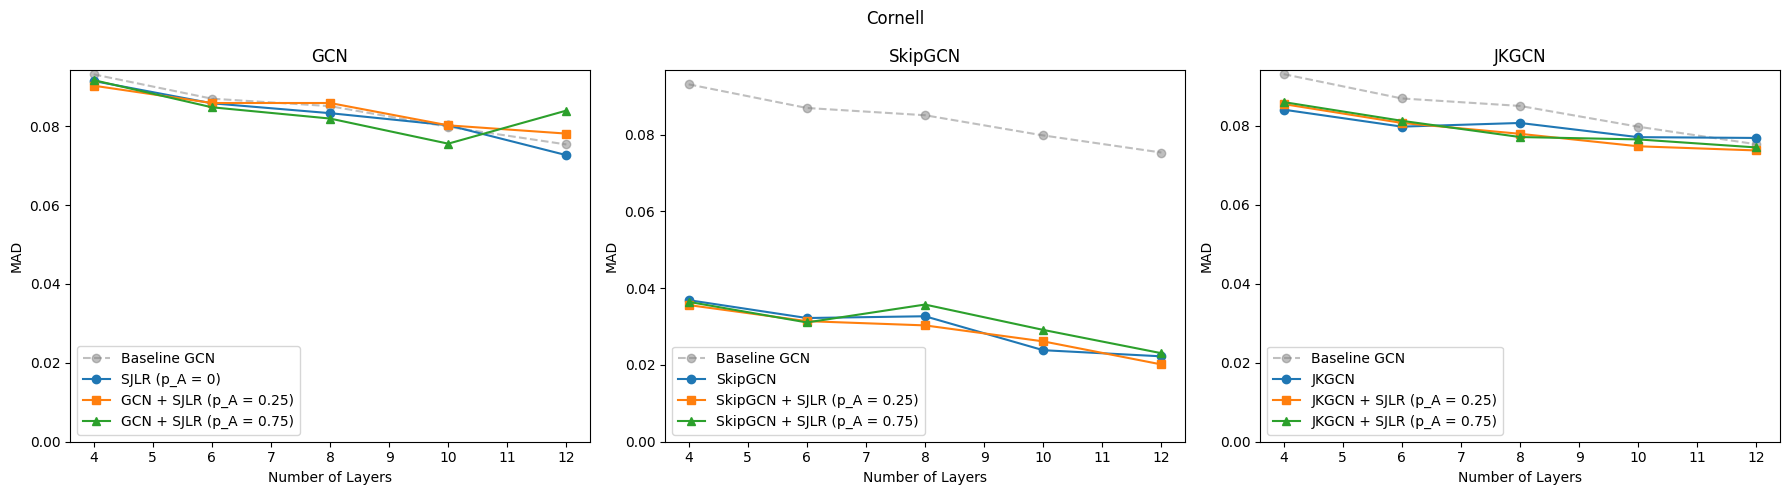

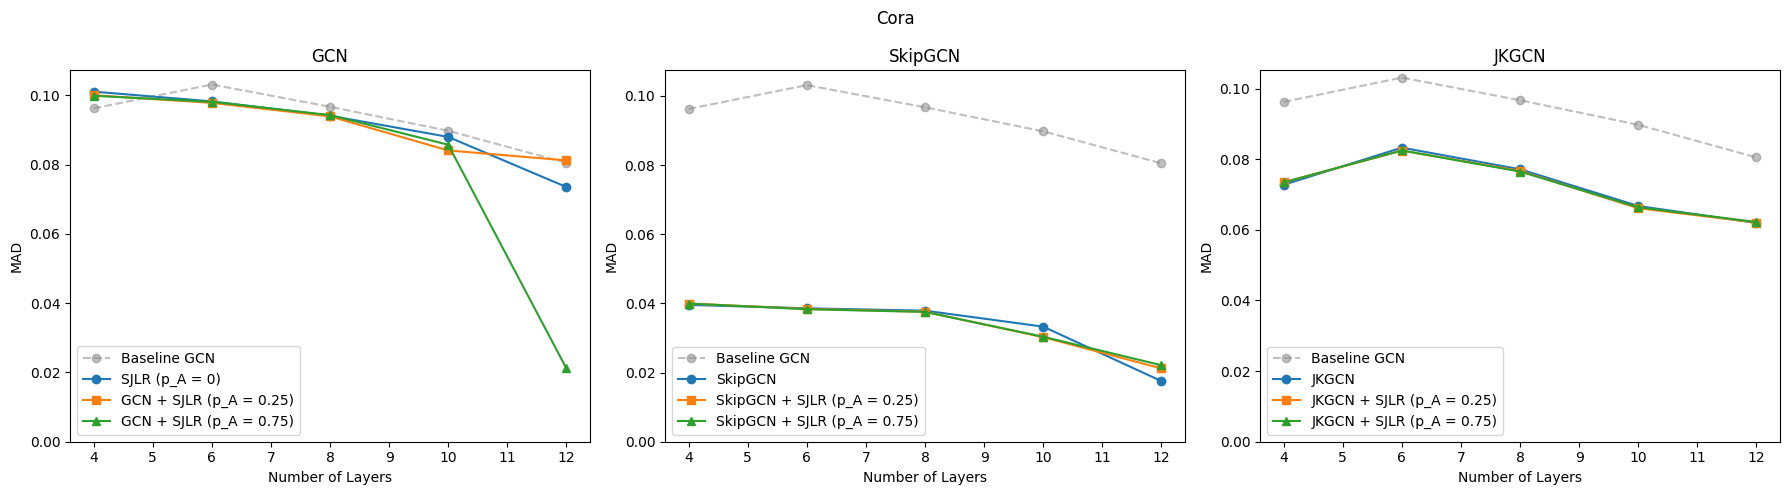

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

layers = [4, 6, 8, 10, 12]
cr_layers = [2, 6, 10, 14]
cornell_data = [
    [cn_gcnsp, cn_gcns2, cn_gcns7],
    [cn_skg, cn_skgs2, cn_skgs7],
    [cn_jkg, cn_jkgs2, cn_jkgs7],
]

cornell_titles = ["GCN", "SkipGCN", "JKGCN"]

cora_data = [
    [cr_gcnsp, cr_gcns2, cr_gcns7],
    [cr_skg, cr_skgs2, cr_skgs7],
    [cr_jkg, cr_jkgs2, cr_jkgs7],
]

cora_titles = ["GCN", "SkipGCN", "JKGCN"]

# Plot settings
baseline_color = "gray"
baseline_label = "Baseline GCN"

# Create Cornell Metrics plot
fig1, axs1 = plt.subplots(1, 3, figsize=(18, 5))
for ax, data, title in zip(axs1, cornell_data, cornell_titles):
    ax.plot(layers, cn_gcn, marker='o', linestyle='--', color=baseline_color, label=baseline_label, alpha=0.5)
    ax.plot(layers, data[0], marker='o', label=f"SJLR (p_A = 0)" if title == 'GCN' else f"{title}")
    ax.plot(layers, data[1], marker='s', label=f"{title} + SJLR (p_A = 0.25)")
    ax.plot(layers, data[2], marker='^', label=f"{title} + SJLR (p_A = 0.75)")
    ax.set_title(title)
    ax.set_xlabel("Number of Layers")
    ax.set_ylabel("MAD")
    ax.set_ylim(bottom=0)  # Force y-axis to start at 0
    ax.legend()
fig1.suptitle("Cornell")
plt.tight_layout()
plt.show()

# Create Cora Metrics plot
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 5))
for ax, data, title in zip(axs2, cora_data, cora_titles):
    ax.plot(layers, cr_gcn, marker='o', linestyle='--', color=baseline_color, label=baseline_label, alpha=0.5)
    ax.plot(layers, data[0], marker='o', label=f"SJLR (p_A = 0)" if title == 'GCN' else f"{title}")
    ax.plot(layers, data[1], marker='s', label=f"{title} + SJLR (p_A = 0.25)")
    ax.plot(layers, data[2], marker='^', label=f"{title} + SJLR (p_A = 0.75)")
    ax.set_title(title)
    ax.set_xlabel("Number of Layers")
    ax.set_ylabel("MAD")
    ax.set_ylim(bottom=0)  # Force y-axis to start at 0
    ax.legend()
fig2.suptitle("Cora")
plt.tight_layout()
plt.show()
